# Linear Regression

### Index
1. Packages
2. Dataset
3. Data Cleaning
4. Feature Plotting
6. Feature Scaling
7. Data Split
8. Compute Cost
9. Gradient
10. Gradient Descent
11. Training the Model
12. Plotting graphs
13. Testing the model
14. Plotting more graphs
15. Scikit-Learn implementation
16. Plotting graphs

### Packages
 - importing libraries for data handling like pandas
 - importing numpy, a polular library for scientific computing
 - importing matplotlib for ploting graphs
 - importing copy, math and os for performing different operations

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy, math
import os
from sklearn.linear_model import SGDRegressor

### Importing Dataset
importing crop yield dataset available at kagglehub.

kagglehub is a service of kaggle where many datasets are hosted.

In [388]:
import kagglehub

path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")
print(path)

C:\Users\asus\.cache\kagglehub\datasets\nehalbirla\vehicle-dataset-from-cardekho\versions\4


### Read dataset
printing the starting 5 examples for testing

In [391]:
df = pd.read_csv(os.path.join(path, "Car details v3.csv"))
print(df.head())
print(len(df))

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

### Cleaning the data
replacing the unit names to only float and using cat codes for converting range of string data to numeric data

In [394]:
df['engine'] = df['engine'].astype(str).str.replace(' CC', '', regex=False).str.strip()
df['engine'] = df['engine'].replace(['', 'nan'], np.nan).astype(float)

df['max_power'] = df['max_power'].astype(str).str.replace(' bhp', '', regex=False).str.strip()
df['max_power'] = df['max_power'].replace(['', 'nan'], np.nan).astype(float)

print(df[['engine', 'max_power']].head())

for col in ['owner', 'transmission', 'fuel']:
    df[col] = df[col].astype('category').cat.codes

# Fill missing values with column mean
df['max_power'] = df['max_power'].fillna(df['max_power'].mean())
df['engine'] = df['engine'].fillna(df['engine'].mean())

   engine  max_power
0  1248.0      74.00
1  1498.0     103.52
2  1497.0      78.00
3  1396.0      90.00
4  1298.0      88.20


### Plotting features against Selling Price
Plotting all 8 features against the output of selling price to identify the features that influence output variable the most

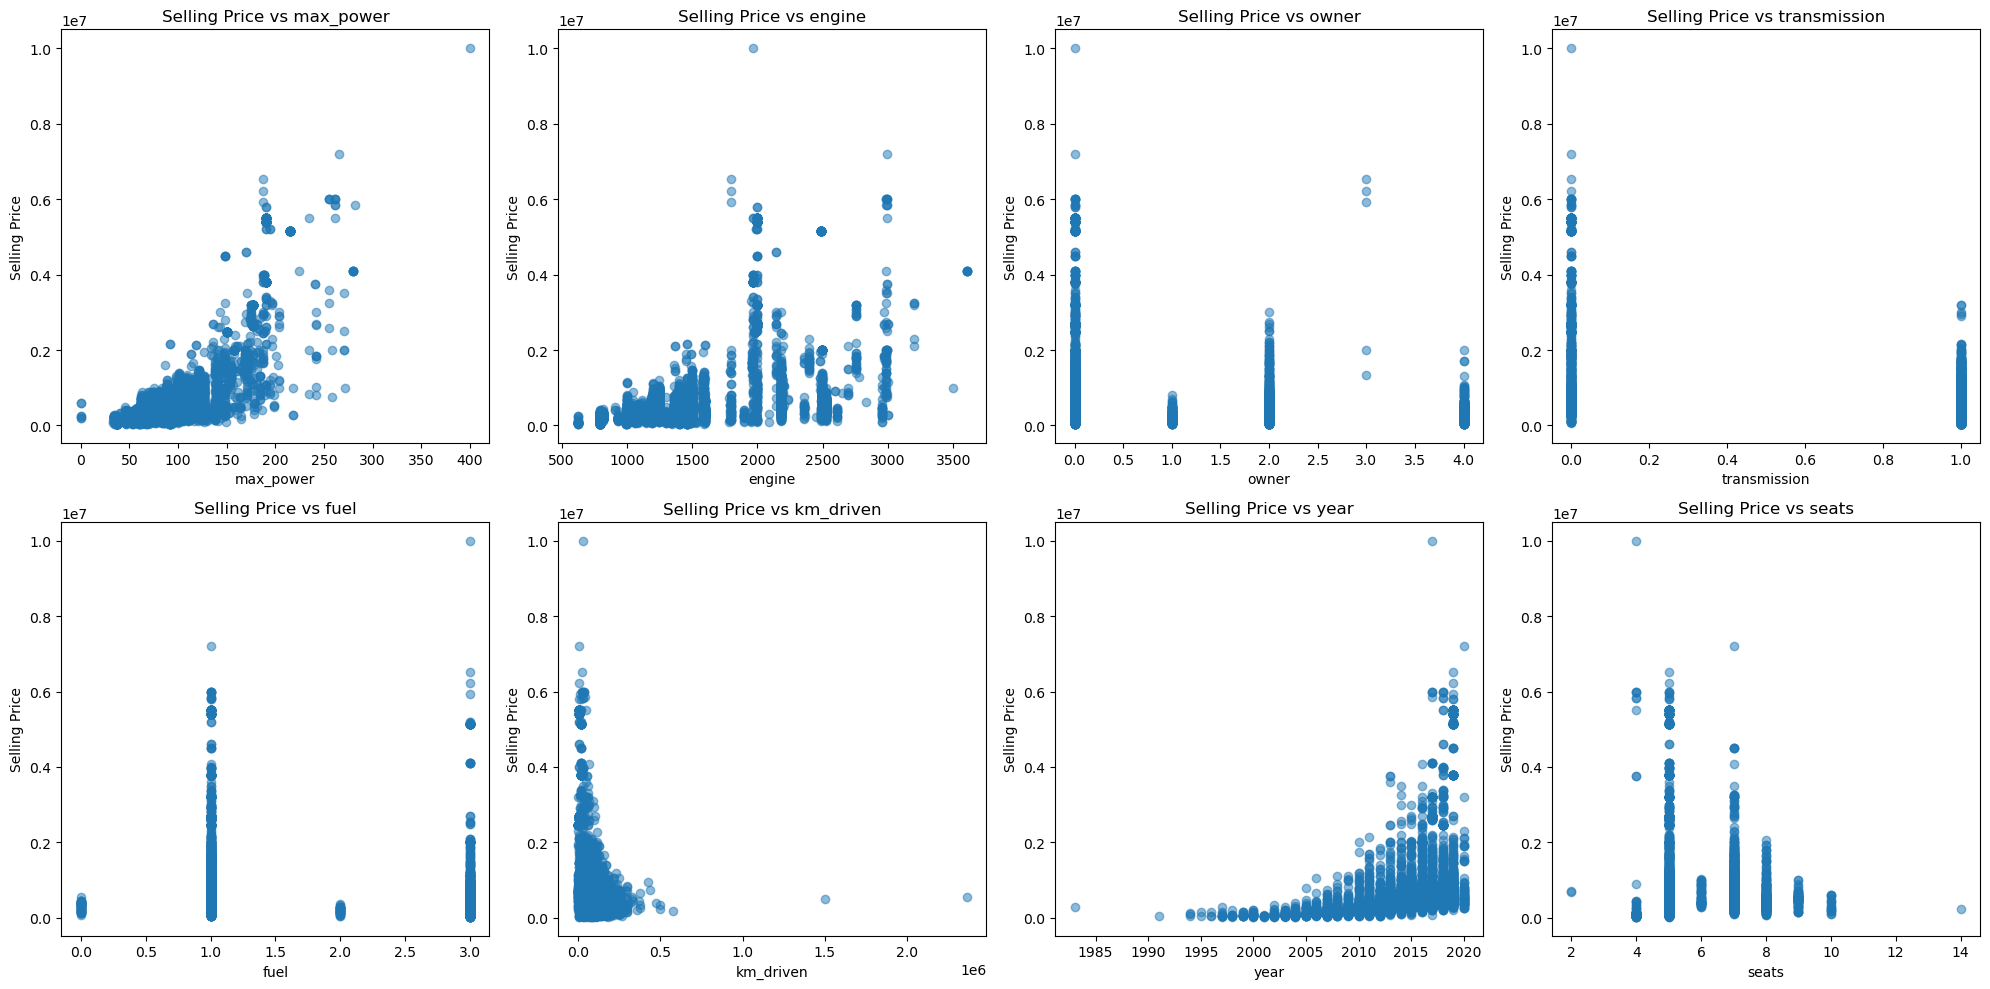

In [397]:
features = ['max_power', 'engine', 'owner', 'transmission', 'fuel', 'km_driven', 'year', 'seats']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns
axes = axes.flatten()  # flatten to 1D for easy indexing

for i, col in enumerate(features):
    axes[i].scatter(df[col], df['selling_price'], alpha=0.5)
    axes[i].set_title(f"Selling Price vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Selling Price')

plt.tight_layout()
plt.show()

By the above plots we can see the relation between different features and the output.
We can see that max_power, engine, year and km_driven has a clear coorelation with the output. The rest features have moderate effect on the output.

We can plot a coorelation heatmap to quantify the effect of a feature on the output.

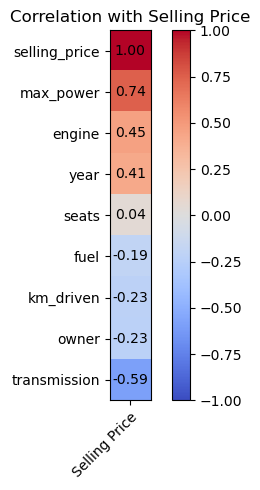

In [400]:
df_corr = df.copy()

# Drop columns that we are not considering for the model
df_corr = df_corr.drop(columns=['name', 'mileage', 'torque', 'seller_type'])

# Compute correlation
corr = df_corr.corr()

# Extract only correlation with selling_price
selling_corr = corr[['selling_price']].sort_values(by='selling_price', ascending=False)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(selling_corr, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks([0])
ax.set_xticklabels(['Selling Price'])
ax.set_yticks(np.arange(len(selling_corr.index)))
ax.set_yticklabels(selling_corr.index)

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate values
for i in range(len(selling_corr.index)):
    value = selling_corr.iloc[i, 0]
    ax.text(0, i, f"{value:.2f}", ha="center", va="center", color="black")

ax.set_title("Correlation with Selling Price")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

We can observe that the feature `seats` doesn't affect the output much. We can safely remove the column from dataset

### Extracting X and y
extracting the training set of features and labels and converting them to numpy array

In [404]:
X = df[['max_power', 'engine', 'owner', 'transmission', 'fuel', 'km_driven', 'year']].to_numpy() # not taking seats as it is inconsequential.
y = df['selling_price'].to_numpy()

# type and dimensions
print(type(X), X.shape)
print(type(y), y.shape)

<class 'numpy.ndarray'> (8128, 7)
<class 'numpy.ndarray'> (8128,)


In [406]:
# Fill missing values with column mean
df['max_power'] = df['max_power'].fillna(df['max_power'].mean())
df['engine'] = df['engine'].fillna(df['engine'].mean())

### Spliting the data into training and testing data
I am keeping 80% data for the model training and the rest for testing

In [409]:
split_ratio = 0.8
split_index = int(len(X_norm) * split_ratio)
print('Spliting index: ',split_index)

# training data
X_train = X[:split_index]
y_train = y[:split_index]

# testing data
X_test = X[split_index:]
y_test = y[split_index:]

print('Training shapes: ', X_train.shape, y_train.shape)
print('Testing shapes: ', X_test.shape, y_test.shape)

Spliting index:  5201
Training shapes:  (5201, 7) (5201,)
Testing shapes:  (2927, 7) (2927,)


### Feature Scaling
Many features have different scales, some have range of thousands and some don't even have a range of 10. This will cause the gradient descent to work slowly.

We will have to perform normalization to give the similar range of values to all features and output variable.

In [412]:
# Z-score normalization
def z_score_norm(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return (X_norm, mu, sigma)

In [414]:
X_train, mu_x, sigma_x = z_score_norm(X_train)
X_test = (X_test - mu_x) / sigma_x
y_train, mu_y, sigma_y = z_score_norm(y_train)
y_test = (y_test - mu_y) / sigma_y

### Compute Cost
I am using squared error cost function to determine the progress of gradient descent

The formula for squared error cost function is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{wb} - y^{(i)})^2$$

In [417]:
def compute_cost(X, y, w, b):
    m = X.shape[0]

    f_wb = np.dot(X, w) + b
    error = f_wb - y
    error_sqr = error ** 2
    total_cost = np.sum(error_sqr) / (2 * m)

    return total_cost

In [419]:
n = X_train.shape[1]
initial_w = np.zeros(n)
initial_b = 0

cost = compute_cost(X_train, y_train, initial_w, initial_b)
print(type(cost))
print(f'Cost at initial w and b: {cost:.3f}')

<class 'numpy.float64'>
Cost at initial w and b: 0.500


### Compute Gradient
Calculate gradient for each step in gradient descent

The formula for gradient is:
$$
\frac{\partial J(w,b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \
$$
$$
\frac{\partial J(w,b)}{\partial w}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) -y^{(i)})x^{(i)} \
$$

In [422]:
def compute_gradient(X, y, w, b):
    m = X.shape[0]
    n = X.shape[1]

    f_wb = np.dot(X, w) + b
    error = f_wb - y
    
    dj_db = np.sum(error) / m
    dj_dw = np.dot(X.T, error) / m

    return(dj_db, dj_dw)

In [424]:
temp_dj_db, temp_dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print('Type of bias gradient: ', type(temp_dj_db))
print('Type of weight gradient: ', type(temp_dj_dw))
print('Gradient at initial w and b: ', temp_dj_db, temp_dj_dw)

Type of bias gradient:  <class 'numpy.float64'>
Type of weight gradient:  <class 'numpy.ndarray'>
Gradient at initial w and b:  -3.552030595993579e-17 [-0.7530537  -0.45132322  0.22088694  0.5955835   0.1916618   0.2155217
 -0.41583041]


### Gradient Descent
In this function we will implement the gradient descent function to train the linear regression. We will also be calling compute_cost and compute_gradient functions from before

The formula for Gradient Descent is:
$$
b = b - \alpha \frac{\partial J(w,b)}{\partial b}
$$
$$
w = w - \alpha \frac{\partial J(w,b)}{\partial w}
$$

In [427]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    m = X.shape[0]
    n = X.shape[1]

    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100000:# prevent resource exhaustion
            cost = cost_function(X, y, w, b)
            J_history.append(cost)

        if i % math.ceil(num_iters / 10) == 0:
            w_history.append(w)
            print(f'Iteration {i:4}: Cost {float(J_history[-1]):8.2f}')

    return w, b, J_history, w_history

### Training the Model
We are going to do 1000 iterations and update w and b to converge at the minima of cost

In [430]:
iterations = 1000
alpha = 0.01

w, b, J_history, w_history = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)
print('w, b found by gradient descent are: ', w, b)

Iteration    0: Cost     0.49
Iteration  100: Cost     0.18
Iteration  200: Cost     0.17
Iteration  300: Cost     0.17
Iteration  400: Cost     0.17
Iteration  500: Cost     0.17
Iteration  600: Cost     0.17
Iteration  700: Cost     0.16
Iteration  800: Cost     0.16
Iteration  900: Cost     0.16
w, b found by gradient descent are:  [ 0.58120609 -0.03131798 -0.02450816 -0.22124654 -0.06630981 -0.07975874
  0.18639397] -1.038395159770298e-15


### Ploting the output
ploting the predicted vs the actual output with different features and number of iterations

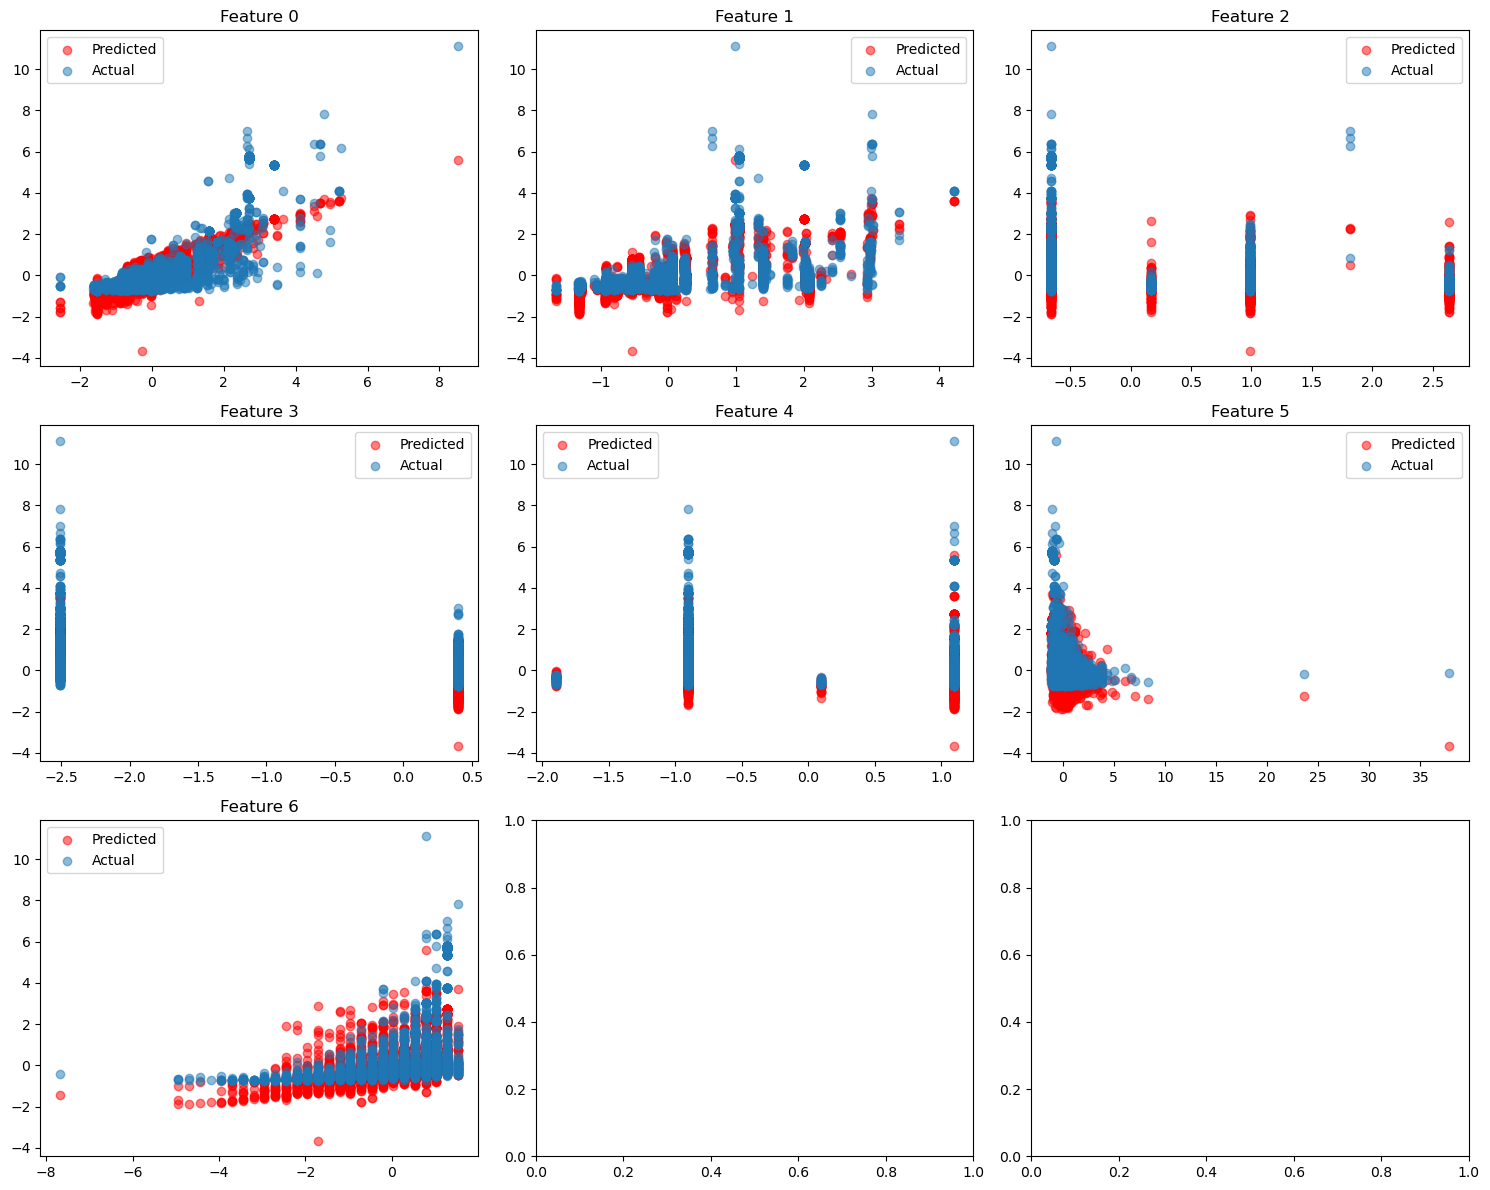

In [433]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))
axes = axes.ravel()

f_wb = np.dot(X_train, w) + b

for i in range(X_train.shape[1]):
    axes[i].scatter(X_train[:, i], f_wb, alpha=0.5, label="Predicted", color="red")
    axes[i].scatter(X_train[:, i], y_train, alpha=0.5, label="Actual")
    axes[i].set_title(f"Feature {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()

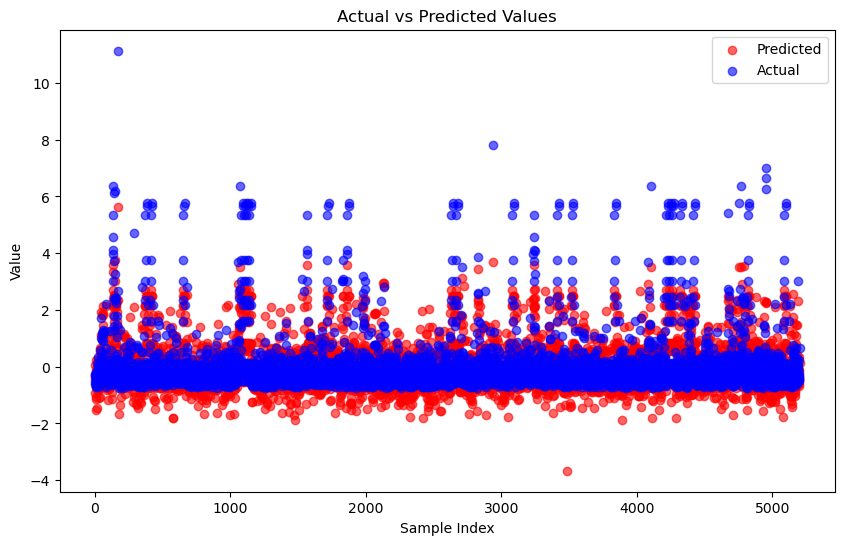

In [434]:
f_wb = np.dot(X_train, w) + b

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_train)), f_wb, c="red", alpha=0.6, label="Predicted")
plt.scatter(range(len(y_train)), y_train, c="blue", alpha=0.6, label="Actual")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

### Testing the Model
We will test the model on the 20% unseen data that we seperated in the start

In [438]:
y_pred = np.dot(X_test, w) + b

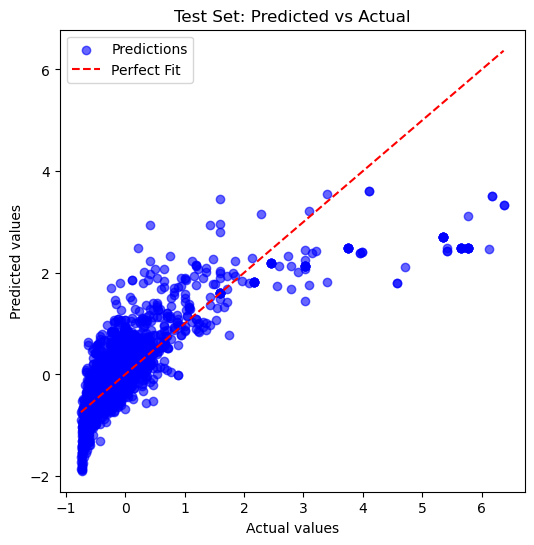

In [440]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Test Set: Predicted vs Actual")
plt.legend()
plt.show()

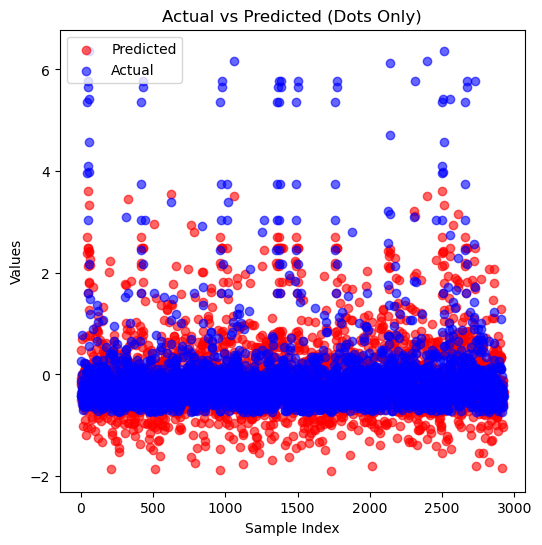

In [442]:
plt.figure(figsize=(6,6))

# Red dots = predicted values
plt.scatter(range(len(y_pred)), y_pred, alpha=0.6, color="red", label="Predicted")

# Blue dots = actual values
plt.scatter(range(len(y_test)), y_test, alpha=0.6, color="blue", label="Actual")

plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted (Dots Only)")
plt.legend()
plt.show()


### Scikit-Learn Implementation
scikit-learn is a open library for traditional ML algorithms. We can check if scikit-learn gets parameters similar to the ones we got.

In [445]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_train, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor()
number of iterations completed: 7, number of weight updates: 36408.0


In [447]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"scikit-learn model parameters:      w: {w_norm}, b:{b_norm}")
print(f"implementation parameters:          w: {w}, b: {b}")

scikit-learn model parameters:      w: [ 0.64662563 -0.04311656 -0.04190992 -0.21720147 -0.07227591 -0.08519091
  0.18989802], b:[0.00437942]
implementation parameters:          w: [ 0.58120609 -0.03131798 -0.02450816 -0.22124654 -0.06630981 -0.07975874
  0.18639397], b: -1.038395159770298e-15


### Testing Scikit-Learn model
Test and plot predictions from the scikit-learn model

In [450]:
sky_pred = np.dot(X_test, w_norm) + b_norm

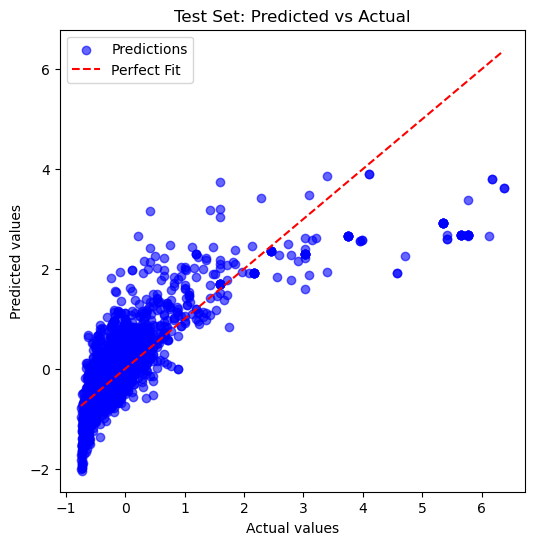

In [452]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, sky_pred, alpha=0.6, color="blue", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Test Set: Predicted vs Actual")
plt.legend()
plt.show()

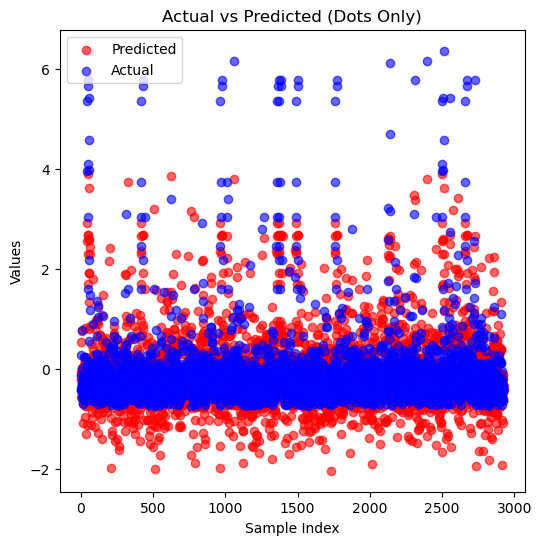

In [454]:
plt.figure(figsize=(6,6))

# Red dots = predicted values
plt.scatter(range(len(sky_pred)), sky_pred, alpha=0.6, color="red", label="Predicted")

# Blue dots = actual values
plt.scatter(range(len(y_test)), y_test, alpha=0.6, color="blue", label="Actual")

plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted (Dots Only)")
plt.legend()
plt.show()

### Comparing scikit-learn with our model

The parameters calculated by both model are similar. 

The small differences are due to:
  1. Different optimization algorithms (batch vs stochastic gradient descent)
  2. Different convergence criteria
  3. sklearn uses more sophisticated stopping conditions